# LSTM model for crypto prediction using Keras

This tutorial illustrates how to get started forecasting time series with LSTM models. Stock market data is a great choice for this because it’s quite regular and widely available to everyone. Please don’t take this as financial advice or use it to make any trades of your own.

We will build a LSTM model to predict crypto price.

You will learn:

- How to transform a raw dataset into something we can use for time series forecasting.
- How to prepare data and fit an LSTM for a multivariate time series forecasting problem.
- How to make a forecast and rescale the result back into the original units.

Reference for how to build a LSTM model for stock market prediction:
* https://www.datacamp.com/community/tutorials/lstm-python-stock-market
* https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html

Reference for how to build a multivariate time series forecasting with LSTM:
* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

In [44]:
# load required packages
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import json
import os
import numpy as np

print(f'pandas: {pd.__version__}')
print(f'json: {json.__version__}')
print(f'numpy: {np.__version__}')

pandas: 1.2.3
json: 2.0.9
numpy: 1.19.5


In [ ]:
# libraries for lstm model (with tensorflow)
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

print(f'tensorflow: {tf.__version__}')

In [ ]:
# libraries for lstm model (with keras)

## Basic data preparation

With this exercise, we will work with **hourly** ticker data for **ETHEUR**. The data was extracted from the Binance API (see the notebook "hist_data_from_binance.ipynb". For reasons of convenience, we will simply load the csv file generated through the other notebook.

The data spans over more than 10,000 data points for a total time of a little more than a year: from 2020-01-03 to 2021-02-28. We have open, high, low, close, volume available for every hour of the days included in the dataset.

In [78]:
# read in the data
filepath = '/Users/siegstedt/projects/trading/binance/data/etheur_2020-01_2021-02_1h.csv'
data = pd.read_csv(filepath, index_col=0, header=0).drop(columns=["datetime"])
data.index.name = "datetime"
print(f"Loaded {data.shape[0]} rows and {data.shape[1]} cols.")

Loaded 10125 rows and 5 cols.


In [81]:
# data inspection
head = data.head(5)
tail = data.tail(5)
mid = pd.DataFrame({"...":["..." for i in data.columns]}).transpose()
mid.columns = data.columns
preview = pd.concat([head, mid, tail])
preview.index.name = data.index.name
print(preview)

                        open     high      low    close      volume
datetime                                                           
2020-01-03 09:00:00    113.8    115.4    113.8    115.4      1.1027
2020-01-03 10:00:00   118.46   118.46   118.46   118.46         0.5
2020-01-03 11:00:00   118.06   118.06   118.02   118.02     1.33288
2020-01-03 12:00:00    118.4    118.4    118.4    118.4     0.08539
2020-01-03 13:00:00    118.4    118.4    118.4    118.4         0.0
...                      ...      ...      ...      ...         ...
2021-02-28 19:00:00  1104.73   1128.1   1100.5  1121.05  2268.75758
2021-02-28 20:00:00  1121.19  1159.63  1119.37   1156.0  2217.30903
2021-02-28 21:00:00  1155.49   1175.4  1150.55   1170.4  2530.15172
2021-02-28 22:00:00  1170.29  1183.28  1163.42   1175.0  2801.53662
2021-02-28 23:00:00   1175.0  1180.97  1156.75  1179.39  1292.76135


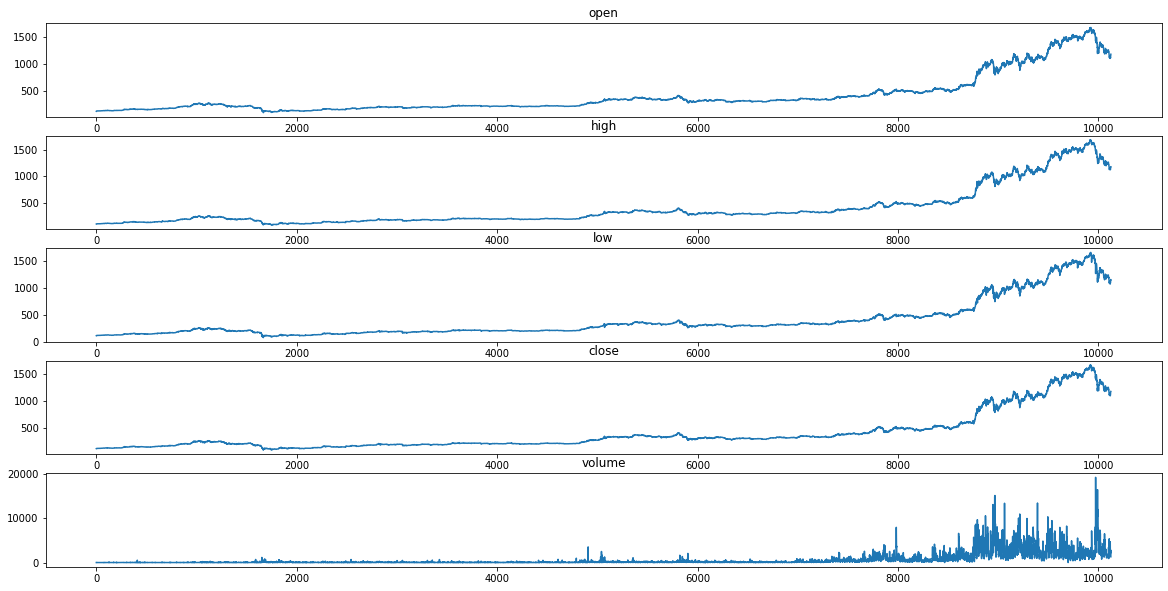

In [48]:
# specify columns to plot
groups = ["open","high","low","close","volume"]
i = 1
# plot each column
plt.figure(figsize=(20,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(data.loc[:, group])
    plt.title(group, y=1, loc='center')
    i += 1
plt.show()

### LSTM Data Preparation

The first step is to prepare the pollution dataset for the LSTM.

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as **predicting the closing price at the current hour (t)** given the market conditions (e.g. open, high, low, volume) at the prior time step.

Some alternate formulations you could explore include:

- Predict the closing price for the next hour based on the market conditions over the last 24 hours.
- Predict the closing price for the next hour as above and given the “expected” market conditions for the next hour.

#### Convert multivariate 

We can transform the dataset using the series_to_supervised() function.

First, the “pollution.csv” dataset is loaded. The wind direction feature is label encoded (integer encoded). This could further be one-hot encoded in the future if you are interested in exploring it.

Next, all features are normalized, then the dataset is transformed into a supervised learning problem. The weather variables for the hour to be predicted (t) are then removed.

Reference:
https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [90]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [99]:
values = data.values
# ensure that all values are floats
values = values.astype('float64')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed = reframed.drop(columns=['var1(t)','var2(t)','var3(t)','var5(t)',])
print(reframed.head(5))

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var4(t)
1   0.016525   0.013103   0.022112   0.016970   0.000058  0.018900
2   0.019463   0.015033   0.025041   0.018900   0.000026  0.018622
3   0.019211   0.014780   0.024765   0.018622   0.000070  0.018862
4   0.019425   0.014995   0.025003   0.018862   0.000004  0.018862
5   0.019425   0.014995   0.025003   0.018862   0.000000  0.018862


Running the example prints the first 5 rows of the transformed dataset. We can see the 5 input variables (input series) and the 1 output variable (close price at the current hour).

This data preparation is simple and there is more we could explore. Some ideas you could look at include:

- Making all series stationary with differencing and seasonal adjustment.
- Providing more than 1 hour of input time steps.

This last point is perhaps the most important given the use of Backpropagation through time by LSTMs when learning sequence prediction problems.

### Train test split

First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first half year of data, then evaluate it on the remaining half years of data. If you have time, consider exploring the inverted version of this test harness.

The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [126]:
# split into train and test sets
values = reframed.values
n_train_hours = 180 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4320, 1, 5) (4320,) (5804, 1, 5) (5804,)


### Define and fit the model

Now we can define and fit our LSTM model.

We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.python.framework import ops

In [109]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
60/60 - 1s - loss: 0.0189 - val_loss: 0.1395
Epoch 2/50
60/60 - 0s - loss: 0.0168 - val_loss: 0.1060
Epoch 3/50
60/60 - 0s - loss: 0.0143 - val_loss: 0.0850
Epoch 4/50
60/60 - 0s - loss: 0.0111 - val_loss: 0.0725
Epoch 5/50
60/60 - 0s - loss: 0.0097 - val_loss: 0.0474
Epoch 6/50
60/60 - 0s - loss: 0.0070 - val_loss: 0.0314
Epoch 7/50
60/60 - 0s - loss: 0.0048 - val_loss: 0.0086
Epoch 8/50
60/60 - 0s - loss: 0.0025 - val_loss: 0.0302
Epoch 9/50
60/60 - 0s - loss: 0.0049 - val_loss: 0.0171
Epoch 10/50
60/60 - 0s - loss: 0.0035 - val_loss: 0.0234
Epoch 11/50
60/60 - 0s - loss: 0.0043 - val_loss: 0.0172
Epoch 12/50
60/60 - 0s - loss: 0.0034 - val_loss: 0.0229
Epoch 13/50
60/60 - 0s - loss: 0.0044 - val_loss: 0.0135
Epoch 14/50
60/60 - 0s - loss: 0.0032 - val_loss: 0.0225
Epoch 15/50
60/60 - 0s - loss: 0.0043 - val_loss: 0.0086
Epoch 16/50
60/60 - 0s - loss: 0.0017 - val_loss: 0.0265
Epoch 17/50
60/60 - 0s - loss: 0.0037 - val_loss: 0.0196
Epoch 18/50
60/60 - 0s - loss: 0.0035 - 

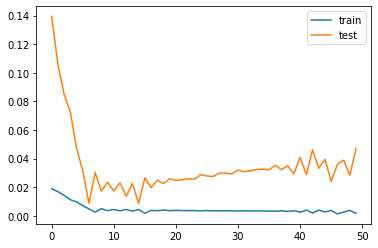

In [111]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Evaluate the model

After the model is fit, we can forecast for the entire test dataset.

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [124]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [125]:
test_X.shape

(5804, 5)

In [127]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 121.629


## Train On Multiple Lag Timesteps

The changes needed to train the model on multiple previous time steps are quite minimal, as follows:

First, we read the data and prepare it as known.

In [214]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [215]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [480]:
# read in the data
filepath = '/Users/siegstedt/projects/trading/binance/data/etheur_2020-01_2021-02_1h.csv'
data = pd.read_csv(filepath, index_col=0, header=0).drop(columns=["datetime"])
data.index.name = "datetime"
# reorder columns for having closed price accessible at the end of the data frame
data = data[['close','open','high','low','volume']]

In [481]:
# data inspection
head = data.head(5)
tail = data.tail(5)
mid = pd.DataFrame({"...":["..." for i in data.columns]}).transpose()
mid.columns = data.columns
preview = pd.concat([head, mid, tail])
preview.index.name = data.index.name
print(preview)

                       close     open     high      low      volume
datetime                                                           
2020-01-03 09:00:00    115.4    113.8    115.4    113.8      1.1027
2020-01-03 10:00:00   118.46   118.46   118.46   118.46         0.5
2020-01-03 11:00:00   118.02   118.06   118.06   118.02     1.33288
2020-01-03 12:00:00    118.4    118.4    118.4    118.4     0.08539
2020-01-03 13:00:00    118.4    118.4    118.4    118.4         0.0
...                      ...      ...      ...      ...         ...
2021-02-28 19:00:00  1121.05  1104.73   1128.1   1100.5  2268.75758
2021-02-28 20:00:00   1156.0  1121.19  1159.63  1119.37  2217.30903
2021-02-28 21:00:00   1170.4  1155.49   1175.4  1150.55  2530.15172
2021-02-28 22:00:00   1175.0  1170.29  1183.28  1163.42  2801.53662
2021-02-28 23:00:00  1179.39   1175.0  1180.97  1156.75  1292.76135


In [482]:
# get values
values = data.values
# ensure that all values are floats
values = values.astype('float64')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

Then, you must frame the problem suitably when calling series_to_supervised(). We will use 3 hours of data as input. Also note, we no longer explictly drop the columns from all of the other fields at ob(t).

In [483]:
# specify the number of lag hours
n_hours = 24
n_features = 5
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(10101, 125)


In [484]:
# split into train and test sets
values = reframed.values
n_train_hours = reframed.shape[0] - 3 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

Next, we need to be more careful in specifying the column for input and output.

We have 3 * 5 + 5 columns in our framed dataset. We will take 3 * 5 or 15 columns as input for the obs of all features across the previous 3 hours. We will take just the close price variable as output at the following hour, as follows:

In [485]:
# split into input and outputs
n_obs = max(1,n_hours) * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(10029, 120) 10029 (10029,)


Next, we can reshape our input data correctly to reflect the time steps and features.

In [486]:
# reshape input to be 3D [samples, timesteps, features]
timesteps = max(1,n_hours)
train_X = train_X.reshape((train_X.shape[0], timesteps, n_features))
test_X = test_X.reshape((test_X.shape[0], timesteps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10029, 24, 5) (10029,) (72, 24, 5) (72,)


Fitting the model is the same.

In [487]:
from tensorflow.keras.layers import Dropout

In [488]:
# design network
model = Sequential()
# first layer
model.add(LSTM(units = 50, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

# second layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# third layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# last layer
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# dense down the net
model.add(Dense(1))

# compile loss
model.compile(loss='mean_squared_error', optimizer='adam')

In [489]:
model.fit(
    train_X, 
    train_y, 
    epochs=50,
    batch_size=72,
    verbose=2,
    shuffle=False
)

Epoch 1/50
140/140 - 8s - loss: 0.0019
Epoch 2/50
140/140 - 4s - loss: 0.0067
Epoch 3/50
140/140 - 3s - loss: 0.0093
Epoch 4/50
140/140 - 3s - loss: 0.0132
Epoch 5/50
140/140 - 3s - loss: 0.0049
Epoch 6/50
140/140 - 3s - loss: 0.0024
Epoch 7/50
140/140 - 3s - loss: 0.0050
Epoch 8/50
140/140 - 3s - loss: 0.0027
Epoch 9/50
140/140 - 3s - loss: 0.0052
Epoch 10/50
140/140 - 4s - loss: 0.0034
Epoch 11/50
140/140 - 4s - loss: 0.0057
Epoch 12/50
140/140 - 3s - loss: 0.0043
Epoch 13/50
140/140 - 3s - loss: 0.0075
Epoch 14/50
140/140 - 3s - loss: 0.0069
Epoch 15/50
140/140 - 3s - loss: 0.0052
Epoch 16/50
140/140 - 3s - loss: 0.0039
Epoch 17/50
140/140 - 3s - loss: 0.0028
Epoch 18/50
140/140 - 3s - loss: 0.0035
Epoch 19/50
140/140 - 3s - loss: 0.0040
Epoch 20/50
140/140 - 3s - loss: 0.0041
Epoch 21/50
140/140 - 3s - loss: 0.0027
Epoch 22/50
140/140 - 3s - loss: 0.0015
Epoch 23/50
140/140 - 3s - loss: 0.0010
Epoch 24/50
140/140 - 3s - loss: 8.0588e-04
Epoch 25/50
140/140 - 3s - loss: 7.0805e-04
E

In [490]:
# fit network
#history = model.fit(
#    train_X, 
#    train_y, 
#    epochs=50, 
#    batch_size=72, 
#    validation_data=(test_X, test_y),
#    verbose=2,
#    shuffle=False
#)

In [491]:
## plot history
#pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
#pyplot.legend()
#pyplot.show()

In [492]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], max(1,n_hours)*n_features))

The only other small change is in how to evaluate the model. Specifically, in how we reconstruct the rows with 8 columns suitable for reversing the scaling operation to get the y and yhat back into the original scale so that we can calculate the RMSE.

The gist of the change is that we concatenate the y or yhat column with the last 7 features of the test dataset in order to inverse the scaling, as follows:

In [493]:
# invert scaling for forecast
n_inverted = n_features - 1
inv_yhat = concatenate((yhat, test_X[:, -n_inverted:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -n_inverted:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [494]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 73.175


<AxesSubplot:>

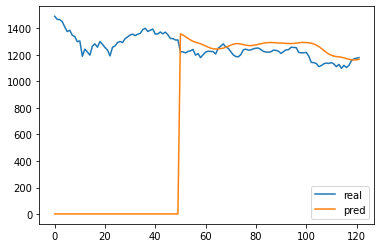

In [495]:
# inspect the time series
past = {
    "real": data.close.iloc[:n_train_hours].tail(50).to_list(),
    "pred": [1 for i in range(50)]
}
predicted = {
    "real": inv_y,
    "pred": inv_yhat,
}

check = pd.concat(
    [
        pd.DataFrame(past),
        pd.DataFrame(predicted)
    ]
).reset_index(drop=True)
check.plot()

In [496]:
check["rel_diff_%"] = (check.pred - check.real) / check.real * 100
check.iloc[49:60,:]

,real,pred,rel_diff_%
49,1312.35,1.000000,-99.923801
50,1223.41,1358.178230,11.015786
51,1222.98,1349.044679,10.307992
52,1215.36,1337.124302,10.018785
53,1226.29,1324.392774,7.999965
54,1230.38,1312.572456,6.680250
55,1241.43,1302.741797,4.938804
56,1198.30,1295.405911,8.103639
57,1209.49,1289.574883,6.621376
58,1179.55,1284.146549,8.867496
